# MP/BME 573 lecture 31: Monte-Carlo Methods (1)

In [13]:
## MP 573 lecture 31
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy import signal, ndimage, misc
from skimage.data import shepp_logan_phantom
import scipy.stats as stats
from matplotlib.image import NonUniformImage

font = {'weight' : 'normal',
        'size'   : 12}

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

## Warm-up problem: Casino's advantage

Let us revisit a problem we know how to solve, but this time let us solve it using Monte-Carlo methods. 

Numbers of hands:
[11, 10001]
Mean earnings:
[  -0.241 -199.176]
Variance of earnings:
[  11.406 9902.085]
P(losing money):
[0.516 0.977]


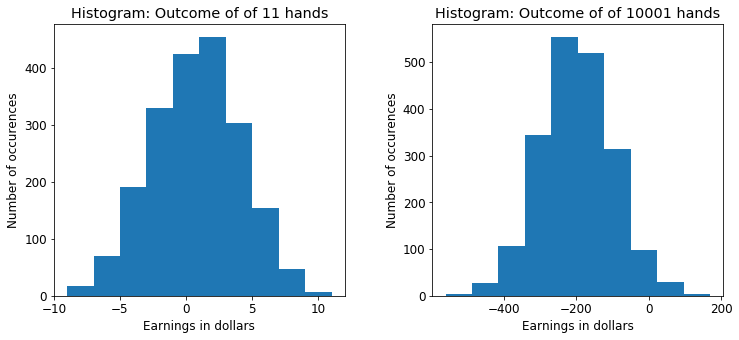

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt


# Bernuilli distribution with parameter p
p = 0.49;

# Number of hands
Nh = [11,10001]

# Number of trials
N = 2000; # Set to 2000 here for speed, used 8000 for the lecture notes
fig = plt.figure(figsize=(12,5))
plt.rc('font', **font)
fig.subplots_adjust(hspace=0.3,wspace=0.3)


# Means and Variances
mymean = np.zeros(np.size(Nh))
myvar = np.zeros(np.size(Nh))
myPloss = np.zeros(np.size(Nh))



for k in range(np.size(Nh)):
    # Generate and show some data
    x = stats.bernoulli.rvs(p, size=[N,Nh[k]])*2 - 1 # Outcome in dollars of each individual hand
    y = np.sum(x,axis=1) # Outcome in dollars after Nh hands
    plt.subplot(1,2,k+1)
    plt.title('Histogram: Outcome of of ' + str(Nh[k]) + ' hands')
    _ = plt.hist(y)#, bins=np.arange(-np.sqrt(Nh[k]),+np.sqrt(Nh[k]),np.sqrt(Nh[k])/50))
    plt.xlabel('Earnings in dollars')
    plt.ylabel('Number of occurences');
    mymean[k] = np.mean(y)
    myvar[k] = np.var(y)
    myPloss[k] = np.sum(y<0)/N

    
print('Numbers of hands:')    
print(Nh)

print('Mean earnings:')    
print(mymean)

print('Variance of earnings:')    
print(myvar)

print('P(losing money):')    
print(myPloss)






## Particle dynamics


In [14]:
# Let us define a function that can tell whether a point is inside the convex hull of a set of points
# https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl

import numpy as np
from scipy.optimize import linprog

def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success


Text(0.5, 1.0, 'Heterogeneous tissue model')

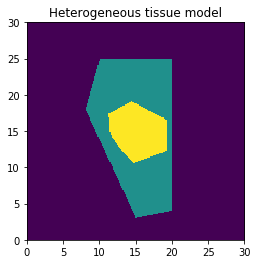

In [37]:
# Let us create a simple heterogeneous tissue model with three different regions

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

tolerance = 0.0000001

x = np.linspace(0,30,201)
Y,X = np.meshgrid(x,x)

points1 = np.array([(10,5), (15, 10), (20, 5), (20, 26), (15,27), (8,12)])
hull1 = ConvexHull(points1)

points2 = np.random.randn(200,2)*1.5 + 15
hull2 = ConvexHull(points2)


grid_points = np.zeros((201*201,2))

grid_points[:,0] = X.flatten()
grid_points[:,1] = Y.flatten()

a = np.shape(grid_points)

# get array of boolean values indicating in hull if True
in_hull1 = np.all(np.add(np.dot(grid_points, hull1.equations[:,:-1].T),
                        hull1.equations[:,-1]) <= tolerance, axis=1)

myim1 = 1.0*np.reshape(in_hull1,(201,201))

# get array of boolean values indicating in hull if True
in_hull2 = np.all(np.add(np.dot(grid_points, hull2.equations[:,:-1].T),
                        hull2.equations[:,-1]) <= tolerance, axis=1)

myim2 = 1.0*np.reshape(in_hull2,(201,201))

fig = plt.figure()
plt.imshow(myim1.T + myim2.T, extent = [x[0], x[-1], x[0], x[-1]]);
plt.title('Heterogeneous tissue model')


<IPython.core.display.Javascript object>


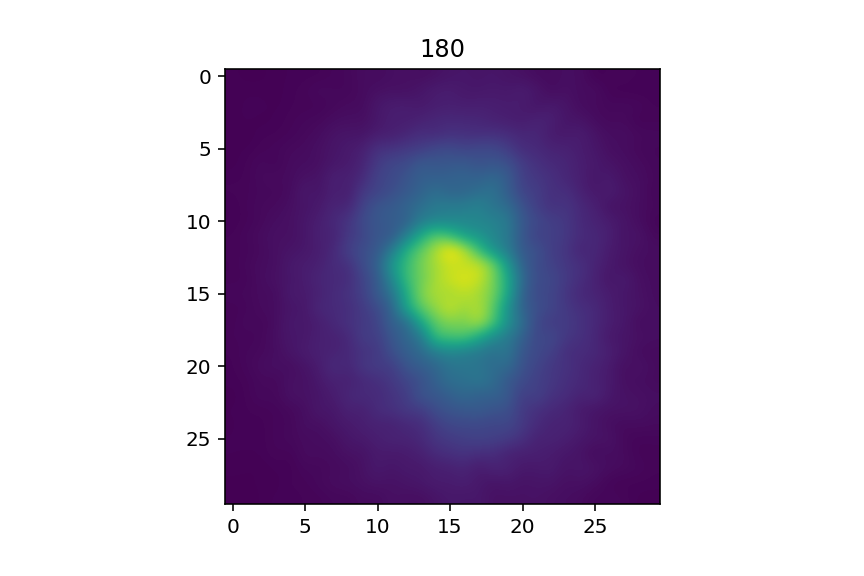

In [55]:
%matplotlib notebook
import matplotlib.pyplot as plt


# Simulate some particles moving in this 2D space, starting from the left
N = 100000;
px0 = np.zeros(N)
py0 = 10 + 10*np.random.rand(N)

# Parameters for steps along each dimension
dxmean = 0.1
dxstd = 0.5
dymean = 0.0
dystd = 0.5
Nsteps = 181

# Speed factors for motion in each of our 3 regions
speed_factors = [1,0.8,0.6] #[1,1,1]#


# Initialize position
px = px0;
py = py0;

cur_points = np.zeros((N,2))


fig = plt.figure()
ax = fig.gca()
fig.show()

for k in range(Nsteps):
    cur_points[:,0] = px
    cur_points[:,1] = py
    
    # Adjust the step 
    factor = np.ones((N))*speed_factors[0]
    in_hull1 = np.all(np.add(np.dot(cur_points, hull1.equations[:,:-1].T),
                        hull1.equations[:,-1]) <= tolerance, axis=1)
    in_hull2 = np.all(np.add(np.dot(cur_points, hull2.equations[:,:-1].T),
                        hull2.equations[:,-1]) <= tolerance, axis=1)
    factor[in_hull1] = speed_factors[1]
    factor[in_hull2] = speed_factors[2]  
    
    dx = stats.norm.rvs(dxmean, dxstd, size=(N))*factor
    dy = stats.norm.rvs(dymean, dystd, size=(N))*factor
    
    px = px + dx
    py = py + dy

    if (k%10) == 0:
        # Show histogram of particle locations
        xedges = np.linspace(0,30,31)
        H, xedges, yedges = np.histogram2d(px, py, bins=(xedges, xedges))
        # Histogram does not follow Cartesian convention 
        # therefore transpose H for visualization purposes.
        H = H.T
        plt.imshow(H, interpolation='bicubic')
        ax.set_title(k)
        fig.canvas.draw()
    

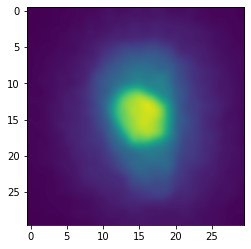

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(H, interpolation='bicubic');